In [33]:
from comsar import PitchTrack
from apollon.audio import AudioFile
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import heapq
from typing import Any, Optional
from scipy.interpolate import interp1d
from scipy.misc import derivative

import apollon.segment as aps
import apollon.signal.tools as ast
from IPython.display import Audio
import glob
import os
from apollon import container
from apollon.io.io import save_to_pickle
from apollon.som import utilities
from apollon.som.utilities import best_match
from apollon.som.som import IncrementalMap
from apollon.io.io import save_to_pickle
from apollon.io.io import load_from_pickle
#from comsar.tracks.helpers import *

In [2]:
#Set Parameters and instantiate Pitch Track
params=aps.SegmentationParams(1102,1102-441,True)
tt = PitchTrack(params)

In [4]:
#Collect all f0 (see Example Notebook 'PitchTrack_f0_Extract') into variable 'pitch'
files = glob.glob('FilePath\\*f0.csv', recursive=True)
pitch=[]
for file in files:
    data=pd.read_csv(file)
    pitch.append(data['0'])

In [ ]:
#Calculate Tonal System, Notes, and ngrams (see manual for details)

#Input
dcent=1    #Analysis precision in cent
noctave=8  #Analysis width in octaves
f0=27.5    #Lowest frequency in analysis
dst=0.1    #Standard deviation of correlation between tonal system and calculated cent values in cent
minlen=15  #Minimum length of adjacent cents to be accepted as a musical event (as a note, etc.)
mindev=60  #Maximum deviation accepted for an event to be a continuous note, etc. in cent. Ext: 50 mean +-50cent

#Return
#        c: Cummulated frequency spectrum
#        co: Cummulated frequency spectrum within one octave, where the frequency of maximum amplitude is
#            vector entry zero and co length is defined by dcent, example: with dcent = 1, co length = 1200
#        maxf: Frequency of maximum amplitude of cummulated spectrum
#        retNames: Names of the ten best matching scales meeting the input frequency data
#        retScale: Theoretical scale values of the ten best matching scales
#        retValue: Contribution of each scale step to the overall correlation for each of the ten best-matching scales
#        retCorr: Overall correlation for the whole scale for each of the ten best-matching scales
#        nnotes: Number of notes in sound
#        notes: Notes of sound as array of pitch_type class instantiations, 
#        with note type ('note', 'pause', etc.), note start, note stop, note args, where arg1 is note in cent above f0
#        cn: Accumulated tonal system spectrum within one octave with precision dcent from pitch events only,
#        Compared to c0 (see above), which is accululated spectrum over all pitches in data

result = []
for i in range(0,len(pitch)):
    result.append(tt.extract_TonalSystem(pitch[i][:], dcent, dst, minlen, mindev, noctave, f0))
    print(i)

In [6]:
#Write results as .csv
res0=[]
res1=[]
res2=[]
res3=[]
res4=[]
res5=[]
res6=[]
res7=[]
res8=[]
res9=[]
for i in range(0,len(pitch)-1):
    res0.append(result[i][0])
    res1.append(result[i][1])
    res2.append(result[i][2])
    res3.append(result[i][3])
    res4.append(result[i][4])
    res5.append(result[i][5])
    res6.append(result[i][6])
    res7.append(result[i][7])
    res8.append(result[i][8])
    res9.append(result[i][9])
pd.DataFrame(res0).to_csv('FilePath\\TonalSystemAnalysisResults0.csv')
pd.DataFrame(res1).to_csv('FilePath\\TonalSystemAnalysisResults1.csv')
pd.DataFrame(res2).to_csv('FilePath\\TonalSystemAnalysisResults2.csv')
pd.DataFrame(res3).to_csv('FilePath\\TonalSystemAnalysisResults3.csv')
#pd.DataFrame(res4).to_csv('D:\\Sounds\\Sammlung_Bader\\Yunnan_CDs\\TonalSystemAnalysisResults4.csv')
#pd.DataFrame(res5).to_csv('D:\\Sounds\\Sammlung_Bader\\Yunnan_CDs\\TonalSystemAnalysisResults5.csv')
pd.DataFrame(res6).to_csv('FilePath\\TonalSystemAnalysisResults6.csv')
pd.DataFrame(res7).to_csv('FilePath\\TonalSystemAnalysisResults7.csv')
pd.DataFrame(res8).to_csv('FilePath\\TonalSystemAnalysisResults8.csv')
pd.DataFrame(res9).to_csv('FilePath\\TonalSystemAnalysisResults9.csv')

In [9]:
#Get results from .csv
res0=pd.read_csv('FilePath\\TonalSystemAnalysisResults0.csv')
res1=pd.read_csv('FilePath\\TonalSystemAnalysisResults1.csv')
res2=pd.read_csv('FilePath\\TonalSystemAnalysisResults2.csv')
res3=pd.read_csv('FilePath\\TonalSystemAnalysisResults3.csv')
#res4=pd.read_csv('D:\\Sounds\\Sammlung_Bader\\Yunnan_CDs\\TonalSystemAnalysisResults4.csv')
#res5=pd.read_csv('D:\\Sounds\\Sammlung_Bader\\Yunnan_CDs\\TonalSystemAnalysisResults5.csv')
res6=pd.read_csv('FilePath\\TonalSystemAnalysisResults6.csv')
res7=pd.read_csv('FilePath\\TonalSystemAnalysisResults7.csv')
res8=pd.read_csv('FilePath\\TonalSystemAnalysisResults8.csv')
res9=pd.read_csv('FilePath\\TonalSystemAnalysisResults9.csv')

In [ ]:
#10 best matching tonal systems of file n, use ret4, ret5, and ret6 for numerical results
n=0
res3[n]

In [ ]:
#Ten best matching tonal systems in cent
res4[n]

In [ ]:
#Contribution of each tone step to the whole correlation between sound input and theoretical tonal system
res5[n]

In [ ]:
#Overall correlation of sound input with ten best-matching tonal systems
res5[n]

In [11]:
#For SOM analysis of Tonal Systems build training vector from tonal system within one octave
#From all f0: res1 or from f0 from only notes: res9
train_X = []
for i in range(0,len(res1)):
    train_X.append(res1.iloc[i]/np.linalg.norm(res1.iloc[i][1:1200]))
train_X = pd.DataFrame(train_X)

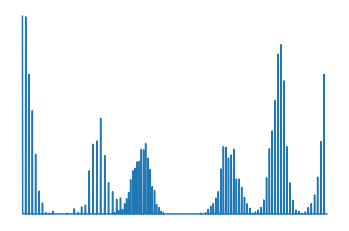

In [15]:
#Example plot of a tonal system
plt.plot(train_X.iloc[3][1:1200])
plt.axis('off')
plt.show()

In [20]:
dx = int(np.sqrt(train_X.shape[0]))+10
dw = train_X.shape[1]
som = IncrementalMap((dx, dx, dw), n_iter=100, eta=0.05, nhr=25)

In [21]:
som.fit(train_X)

In [22]:
um = som.umatrix()
bmu, err = best_match(som.weights, train_X, som.metric)
px, py = np.unravel_index(bmu, som.shape)

In [57]:
#If different training sets are used, each might be given a color
target = [('a', i+1) for i in range(0,len(lal1))] + [('b', i+1) for i in range(0,len(lbl1))] + [('c', i+1) for i in range(0,len(lcl1))]

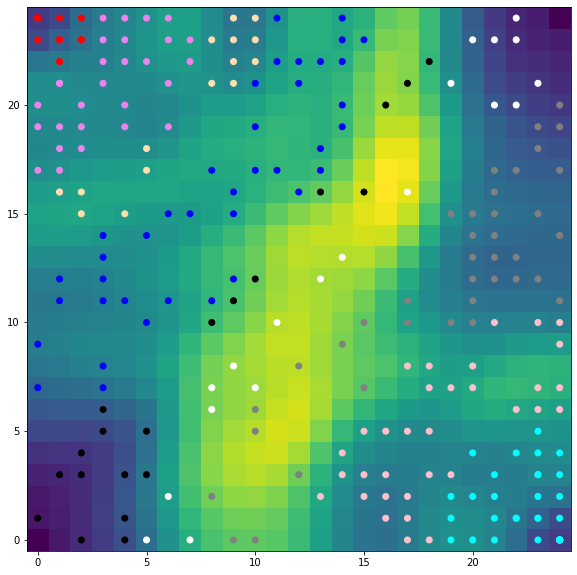

In [62]:
#Plot SOM with fitted training data fitted
color_map = {'a': 'red', 'b': 'violet','c':'navajowhite','d': 'blue','e':'black','f':'white','g':'gray','h':'pink','i':'aqua','j':'lime'}

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(um, aspect='equal', origin='lower')

ax.scatter(py, px, c=[color_map[t[0]] for t in target])

In [19]:
#x positions of training vector fit into trained SOM
px

array([ 0,  0, 13, 13, 13, 13,  0,  0, 13,  8,  0, 13,  0,  4,  6,  0,  4,
       11,  8, 13, 10,  6], dtype=int32)

In [20]:
#y positions of training vector fit into trained SOM
py

array([13,  0,  3,  7,  0, 13, 13,  6,  0,  0, 10,  0,  0, 13,  6,  0,  0,
       13, 13, 13, 13,  6], dtype=int32)

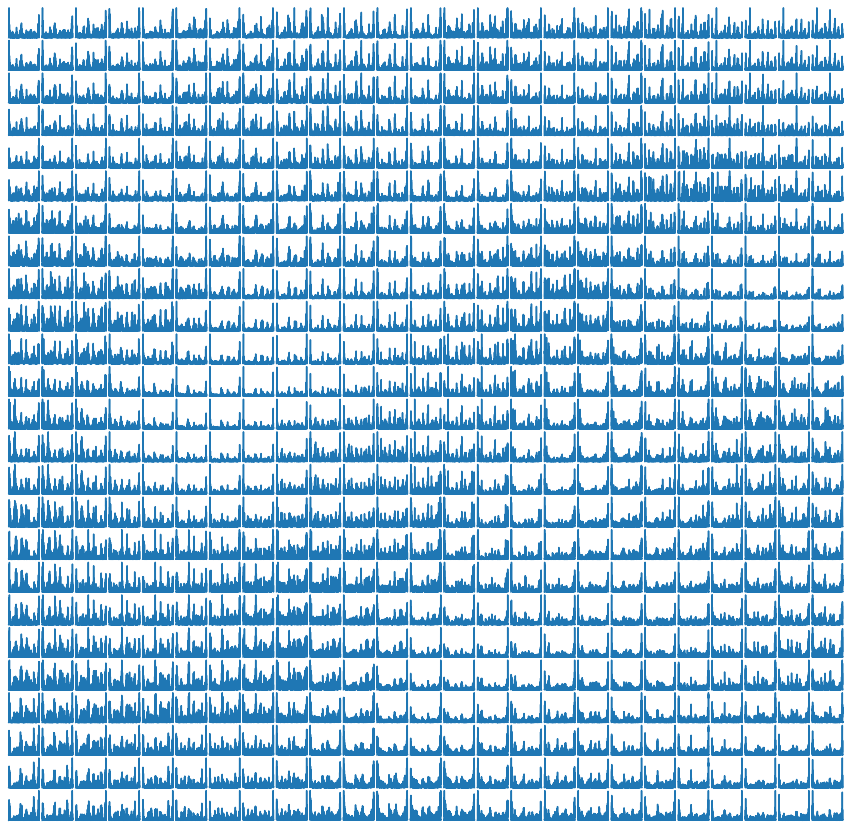

In [30]:
#Plot SOM with weights, here Tonal Systems
fig = plt.figure(figsize=(dx, dx))
fig.subplots_adjust(hspace=0, wspace=0)
k=1
for j in range(dx-2, -1,-1):
    for i in range(0, dx):
        ax = fig.add_subplot(dx, dx, k)
        ax.plot(som.weights[j*dx+i][0:1201])
        ax.axis('off')
        k=k+1